In [19]:
from spyral_utils.plot import Histogrammer
from spyral.core.constants import QBRHO_2_P
from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from pathlib import Path
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import vector

%matplotlib widget

In [20]:
# Load data config
workspace_path = Path("/Volumes/e20009_sim/engine_v0.3.0/elastic_0-180cm/workspace")
target_material_path = Path("/Users/attpc/Desktop/e20009_analysis/e20009_analysis/e20009_parameters/e20009_target.json")

solver_result_path = workspace_path / "InterpLeastSqSolver"
beam_events_path = workspace_path / "beam_events"

# Run number range (inclusive)
run_min = 1
run_max = 18

# The nucleus we observe (the one fitted)
ejectile_z = 1
ejectile_a = 2

# The incoming nucleus (the beam)
projectile_z = 4
projectile_a = 10

# The target nucleus
target_z = 1
target_a = 2

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

In [21]:
# Setup nuclear data objects
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')

ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 2H(10Be, 2H)10Be
Target material: (Gas)2H2


In [22]:
# Define parameters used for analysis, ELASTIC AND INELASTIC

proj_energy_start = 93.5        # Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.700    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 20.0    # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 90.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

redchi = 10     # Maximum reduced chi squared value (inclusive)

In [23]:
# Create dictionary to store results from analysis

results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)
results["event"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [24]:
# Analysis data

target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})
for run in range(run_min, run_max+1):
    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"
    if not path.exists():
        continue
    df = pl.scan_parquet(path)

    #Apply gates to data
    df = (df.filter((pl.col("vertex_z") >= min_z) 
                   & (pl.col("vertex_z") <= max_z)
                   & (pl.col("redchisq") <= redchi))
            .sort("polar", descending=True)
            .unique("event", keep='first')
            .sort("event", descending = False)
            .collect()
    )

    # mask = df.select("event").is_duplicated()
    # df = df.filter(mask).sort("polar", descending=False).unique("event", keep='first').sort("event", descending = False)
    # print(df)

    # Construct the projectile vectors (beam)
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
        "px": np.zeros(len(projectile_ke)),
        "py": np.zeros(len(projectile_ke)),
        "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
        "E": projectile_ke + projectile.mass
    })

    # Construct the ejectile vectors (detected)
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
        "px": momentum * np.sin(polar) * np.cos(az),
        "py": momentum * np.sin(polar) * np.sin(az),
        "pz": momentum * np.cos(polar),
        "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
    })

    # Get reduced chi-squared information
    cs = df.select('redchisq').to_numpy().flatten()

    # Get vertex z position
    zvert=df.select('vertex_z').to_numpy().flatten()

    # Do the kinematics
    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    # Calculate CM scattering angle 
    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    # Event number
    ev_num = df.select(['event']).to_numpy()

    # Fill histograms and arrays
    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)
    results["event"] = np.append(results["event"], ev_num)

In [35]:
# Load in simulated kinematics

kine_path = "/Volumes/e20009_sim/engine_v0.3.0/elastic_0-180cm/elastic_kine.parquet"

kine_f = pl.scan_parquet(kine_path)
kine_f = kine_f.filter(pl.col("event").is_in(results["event"]))
# print(kine_f.select(pl.col('event')).count().collect().item()/4)

beam_coords = (
    kine_f.gather_every(4, offset=1)
    .select("px", "py", "pz", "energy")
    .collect()
    .to_numpy()
)
beam_vectors = vector.array(
    {
        "px": beam_coords[:, 0],
        "py": beam_coords[:, 1],
        "pz": beam_coords[:, 2],
        "E": beam_coords[:, 3],
    }
)

product_coords = (
    kine_f.gather_every(4, offset=3)
    .select("px", "py", "pz", "energy")
    .collect()
    .to_numpy()
)
product_vectors = vector.array(
    {
        "px": product_coords[:, 0],
        "py": product_coords[:, 1],
        "pz": product_coords[:, 2],
        "E": product_coords[:, 3],
    }
)

light_en = (kine_f.gather_every(4, offset=2)
    .select("energy")
    .collect()
    .to_numpy()
)

light_en = light_en - ejectile.mass
cm_ang_det = product_vectors.boostCM_of(beam_vectors + target_vector).theta 

In [17]:
print(results["polar"].shape)
print(kine_f.select(pl.col('event')).count().collect().item()/4)

(954943,)
954943.0


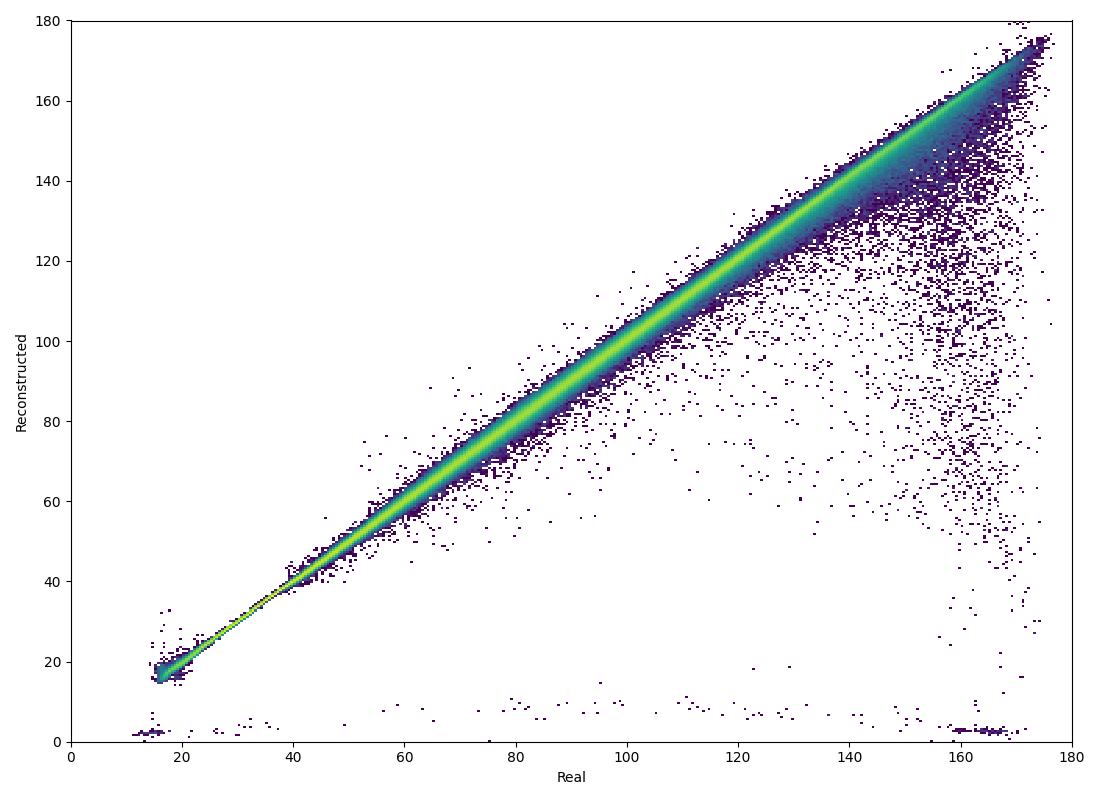

In [18]:
# # Create histogram tool
# grammer = Histogrammer()

# grammer.add_hist2d('heater', (360, 360), ((0.0, 180.0), (0.0, 180.0)))
# grammer.fill_hist2d('heater', np.rad2deg(cm_ang_det), np.rad2deg(results["cm_polar"]))
# hist = grammer.get_hist2d("heater")

# fig, ax = plt.subplots(1,1)
# mesh = ax.pcolormesh(hist.x_bins, hist.y_bins, hist.counts,  norm='log')
# ax.set_xlabel("Real")
# ax.set_ylabel("Reconstructed")
# fig.set_figheight(8.0)
# fig.set_figwidth(11.0)
# fig.tight_layout()

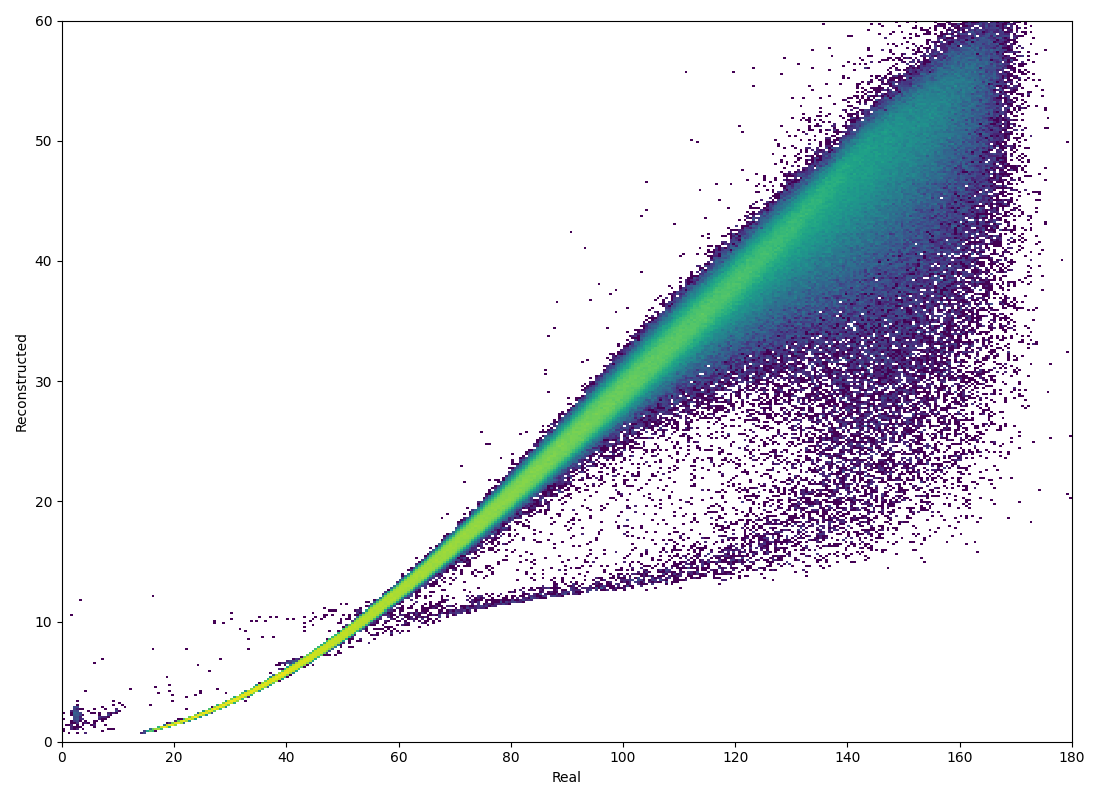

In [45]:
# Create histogram tool
grammer = Histogrammer()

grammer.add_hist2d('heater', (360, 360), ((0.0, 180.0), (0.0, 60)))
grammer.fill_hist2d('heater', np.rad2deg(results["cm_polar"]), results["kinetic_energy"])
hist = grammer.get_hist2d("heater")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(hist.x_bins, hist.y_bins, hist.counts,  norm='log')
ax.set_xlabel("Real")
ax.set_ylabel("Reconstructed")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()